# Exploratory Data Analysis Part 2: Feature Engineering

In [404]:
import numpy as np
# Libraries importing
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

from lightgbm import LGBMClassifier

from utils import model_evaluation


In [405]:
# GLOBAL CONSTANTS
SEED = 42

In [406]:
# Read training data
data = pd.read_csv('./preprocessed_data.csv', index_col=0)

/tmp/ipykernel_29308/1700290082.py:2: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./preprocessed_data.csv', index_col=0)


In [407]:
# Take a look on data inside the training dataset
data.head(10)

,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,NACIONALITY,RESIDENCIAL_STATE,FLAG_RESIDENCIAL_PHONE,...,FLAG_PROFESSIONAL_PHONE,PROFESSIONAL_PHONE_AREA_CODE,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,PRODUCT,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,,,,,,,,,,,,,,,,,,,,,
1,5,Web,1,F,6.0,1,RN,1,RN,Y,...,N,NaN,0,9.0,4.0,1,32,595,595,1
2,15,Carga,1,F,2.0,0,RJ,1,RJ,Y,...,N,NaN,0,11.0,4.0,1,34,230,230,1
3,5,Web,1,F,2.0,0,RN,1,RN,Y,...,N,NaN,0,11.0,NaN,1,27,591,591,0
4,20,Web,1,F,2.0,0,PE,1,PE,N,...,N,NaN,0,NaN,NaN,1,61,545,545,0
5,10,Web,1,M,2.0,0,RJ,1,RJ,Y,...,N,NaN,0,9.0,5.0,1,48,235,235,1
6,10,NaN,1,M,2.0,0,MG,1,MG,Y,...,N,NaN,0,9.0,2.0,2,40,371,371,1
7,15,Carga,1,F,2.0,2,BA,1,BA,Y,...,N,NaN,0,11.0,4.0,1,40,413,413,1
8,25,Web,1,F,1.0,0,MG,1,SP,N,...,Y,5.0,0,11.0,2.0,1,28,686,686,0
9,15,NaN,1,F,1.0,0,SP,1,SP,Y,...,N,NaN,0,0.0,2.0,2,31,172,172,0


In [408]:
# Read the numerical and categorical features txt files
num_features = []
with open('./numerical_features_names.txt', 'r') as f:
    for line in f:
        # Read line by line and append top empty list
        num_features.append(line.split('\n')[0])

cat_features = []
with open('./categorical_features_names.txt', 'r') as f:
    for line in f:
        # Read line by line and append top empty list
        cat_features.append(line.split('\n')[0])

In [409]:
# Convert dtypes to the right ones
# First use suggested dtypes from pandas core
data = data.convert_dtypes()
# Remove Target variable from features
cat_features.remove('TARGET_LABEL_BAD=1')
# Then use the lists generated before
for col in cat_features:
    # First to string
    data[col] = data[col].astype('string')
    data[col] = pd.Categorical(data[col])

# As Pandas could introduce pd.NA values in some features
# when converting them to categorical, let's replace them with np.nan by casting
# int columns to float32
cols_to_float = data.select_dtypes(include='int').columns
data[cols_to_float] = data[cols_to_float].astype(dtype='float32')

In [410]:
cat_features

['STATE_OF_BIRTH',
 'FLAG_VISA',
 'FLAG_AMERICAN_EXPRESS',
 'QUANT_SPECIAL_BANKING_ACCOUNTS',
 'FLAG_DINERS',
 'PROFESSIONAL_PHONE_AREA_CODE',
 'FLAG_OTHER_CARDS',
 'APPLICATION_SUBMISSION_TYPE',
 'FLAG_PROFESSIONAL_PHONE',
 'RESIDENCIAL_ZIP_3',
 'MARITAL_STATUS',
 'PROFESSIONAL_STATE',
 'SEX',
 'COMPANY',
 'QUANT_BANKING_ACCOUNTS',
 'POSTAL_ADDRESS_TYPE',
 'FLAG_RESIDENCIAL_PHONE',
 'PROFESSIONAL_ZIP_3',
 'RESIDENCIAL_PHONE_AREA_CODE',
 'FLAG_MASTERCARD',
 'PAYMENT_DAY',
 'RESIDENCIAL_STATE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'RESIDENCE_TYPE',
 'NACIONALITY']

##Dataset Split

In [411]:
# Split data into features and label
X, y = data.drop(columns=['TARGET_LABEL_BAD=1']), data['TARGET_LABEL_BAD=1']
# Split dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
# Split train datasets into train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED
)

In [412]:
## Build processing pipeline
# Create individual transformers
num_transformer = Pipeline(
        steps=[
            ('imputer' , SimpleImputer(strategy='median')),
            ('scaler'  , RobustScaler())
        ]
)

cat_transformer = Pipeline(
        steps=[
            ('imputer2', SimpleImputer(missing_values=pd.NA,
                                      strategy='most_frequent')),
            ('encoder' , OneHotEncoder(drop='if_binary',
                                       #dtype='int8',
                                       handle_unknown='ignore',
                                       sparse=False))
        ]
)

# Ensemble all the transformers
preprocessor = ColumnTransformer(
        transformers=[
            ('num' , num_transformer , num_features),
            ('cat' , cat_transformer , cat_features)
        ]
)

In [413]:
# Use ColumnTransformer 'preprocessor' to process data
# Train data
X_train_pre = preprocessor.fit_transform(X=X_train)
# Validation data
X_val_pre = preprocessor.transform(X=X_val)
# Test data
X_test_pre = preprocessor.transform(X=X_test)

/home/w/AnyOne_AI/cohort-02-2022/Final_Project/proyecto-final-anyoneai/FP_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [5, 9, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/w/AnyOne_AI/cohort-02-2022/Final_Project/proyecto-final-anyoneai/FP_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 5, 9, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Model Selection

Let's define a Baseline Model to take it as reference.

In [414]:
baseline_classifier = RandomForestClassifier(random_state=SEED, n_jobs=-1)

In [415]:
baseline_classifier.fit(X=X_train_pre, y=y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [416]:
blm_predict = baseline_classifier.predict(X=X_val_pre)

In [417]:
blm_metrics = model_evaluation.get_performance(predictions=blm_predict,
                                               y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.7352
Precision: 0.4359
Recall: 0.036
F1 Score: 0.0666

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.74      0.98      0.85      6642
         1.0       0.44      0.04      0.07      2358

    accuracy                           0.74      9000
   macro avg       0.59      0.51      0.46      9000
weighted avg       0.66      0.74      0.64      9000


Prediction Confusion Matrix:
------------------------------
      0    1
0  6532  110
1  2273   85


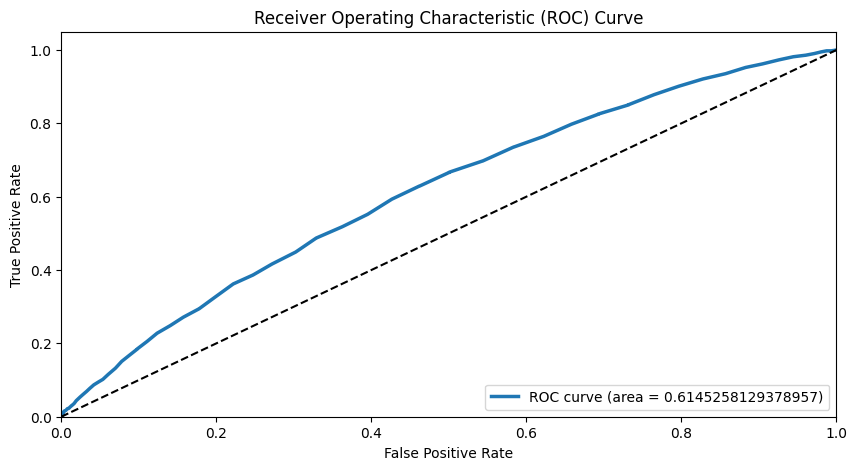

AUC Score of Baseline Model is 0.6145


In [418]:
blm_roc_auc = model_evaluation.plot_roc(model=baseline_classifier,
                                        y_test=y_val,
                                        features=X_val_pre)

print(f'AUC Score of Baseline Model is {round(blm_roc_auc, 4)}')

In [419]:
# Try with another classifier
lgb_clf = LGBMClassifier(random_state=SEED)
# Training
lgb_clf.fit(X=X_train_pre, y=y_train)
# Prediction
lgb_pred = lgb_clf.predict(X=X_val_pre)

In [420]:
lgb_metrics = model_evaluation.get_performance(predictions=lgb_pred,
                                               y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.7371
Precision: 0.4714
Recall: 0.028
F1 Score: 0.0528

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.74      0.99      0.85      6642
         1.0       0.47      0.03      0.05      2358

    accuracy                           0.74      9000
   macro avg       0.61      0.51      0.45      9000
weighted avg       0.67      0.74      0.64      9000


Prediction Confusion Matrix:
------------------------------
      0   1
0  6568  74
1  2292  66


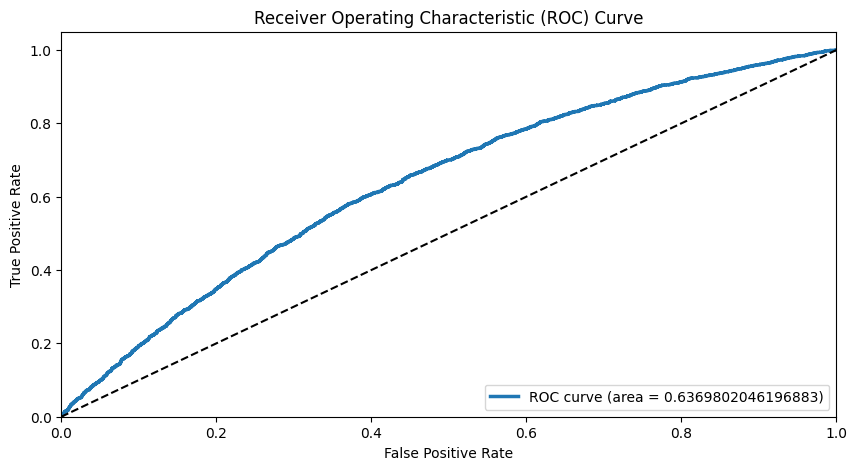

In [421]:
lgb_auc_score = model_evaluation.plot_roc(model=lgb_clf,
                                          y_test=y_val,
                                          features=X_val_pre)